In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pymc as pm
import pymc.sampling_jax
import xarray as xr
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
penguins = pd.read_csv("../data/penguins.csv")
# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = penguins.loc[~missing_data]
penguins.shape

(333, 8)

In [4]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [5]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean", "std", "count"])
)
summary_stats.round(1)

body_mass_g             
                 mean    std count
species                           
Adelie         3706.2  458.6   146
Chinstrap      3733.1  384.3    68
Gentoo         5092.4  501.5   119

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


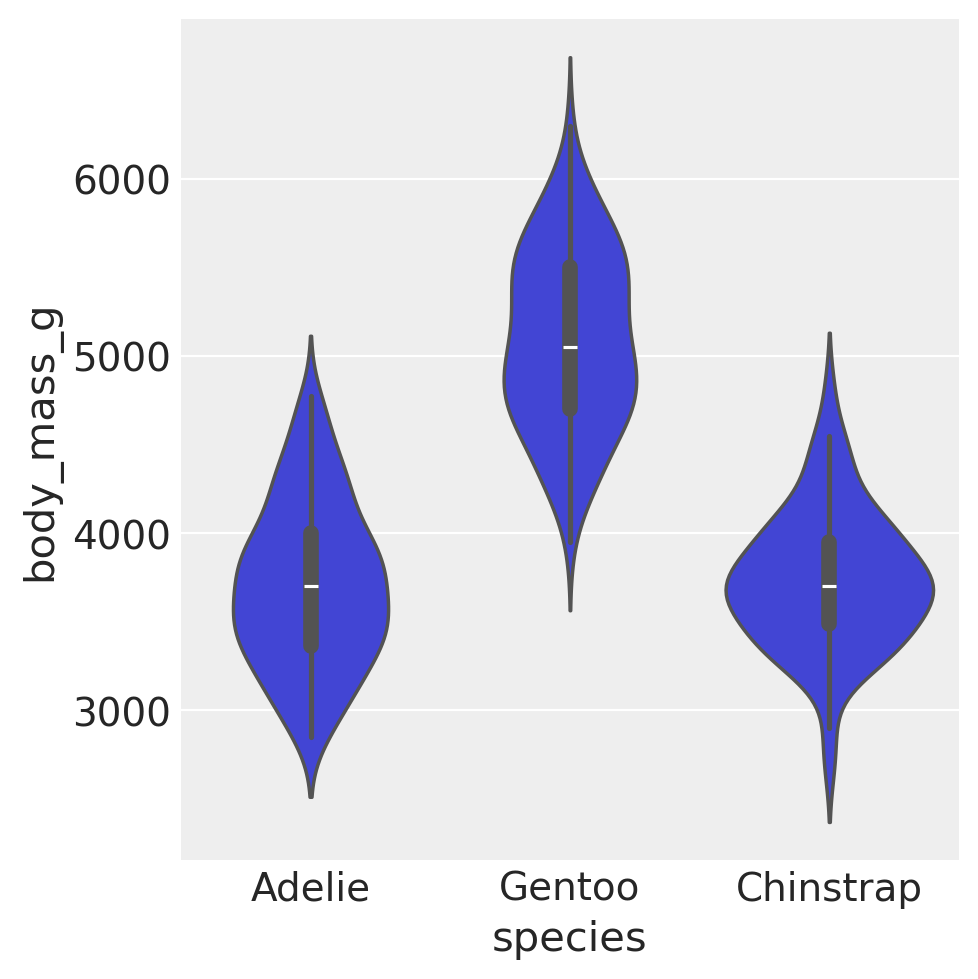

In [6]:
sns.catplot(kind="violin", data=penguins, x="species", y="body_mass_g")
plt.show()

In [7]:
[penguins["body_mass_g"].mean(), penguins["body_mass_g"].std()]

[4207.057057057057, 805.2158019428964]

In [8]:
coords = {"species": ["Adelie", "Gentoo", "Chinstrap"]}

with pm.Model(coords=coords) as model:
    # Constant data for species indices
    species_idx = pm.ConstantData(
        "species_idx",
        penguins["species"].replace({"Adelie": 0, "Gentoo": 1, "Chinstrap": 2}).values,
    )

    # Normal priors for mu and sigma for each species
    mu = pm.Normal("mu", 4200, 1000, dims="species")
    sigma = pm.HalfNormal("sigma", 500, dims="species")

    # Likelihood
    y = pm.Normal(
        "y",
        mu=mu[species_idx],
        sigma=sigma[species_idx],
        observed=penguins["body_mass_g"],
    )

In [9]:
species_idx_values = (
    penguins["species"].replace({"Adelie": 0, "Gentoo": 1, "Chinstrap": 2}).values
)
print(species_idx_values)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


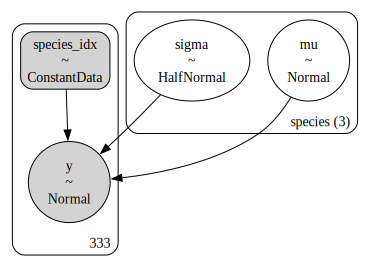

In [10]:
pm.model_to_graphviz(model)

In [11]:
with model:
    idata_prior = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [mu, sigma, y]


/var/folders/cl/wwjrsxdd5tz7y9jr82nd5hrw0000gn/T/ipykernel_79022/2431238427.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


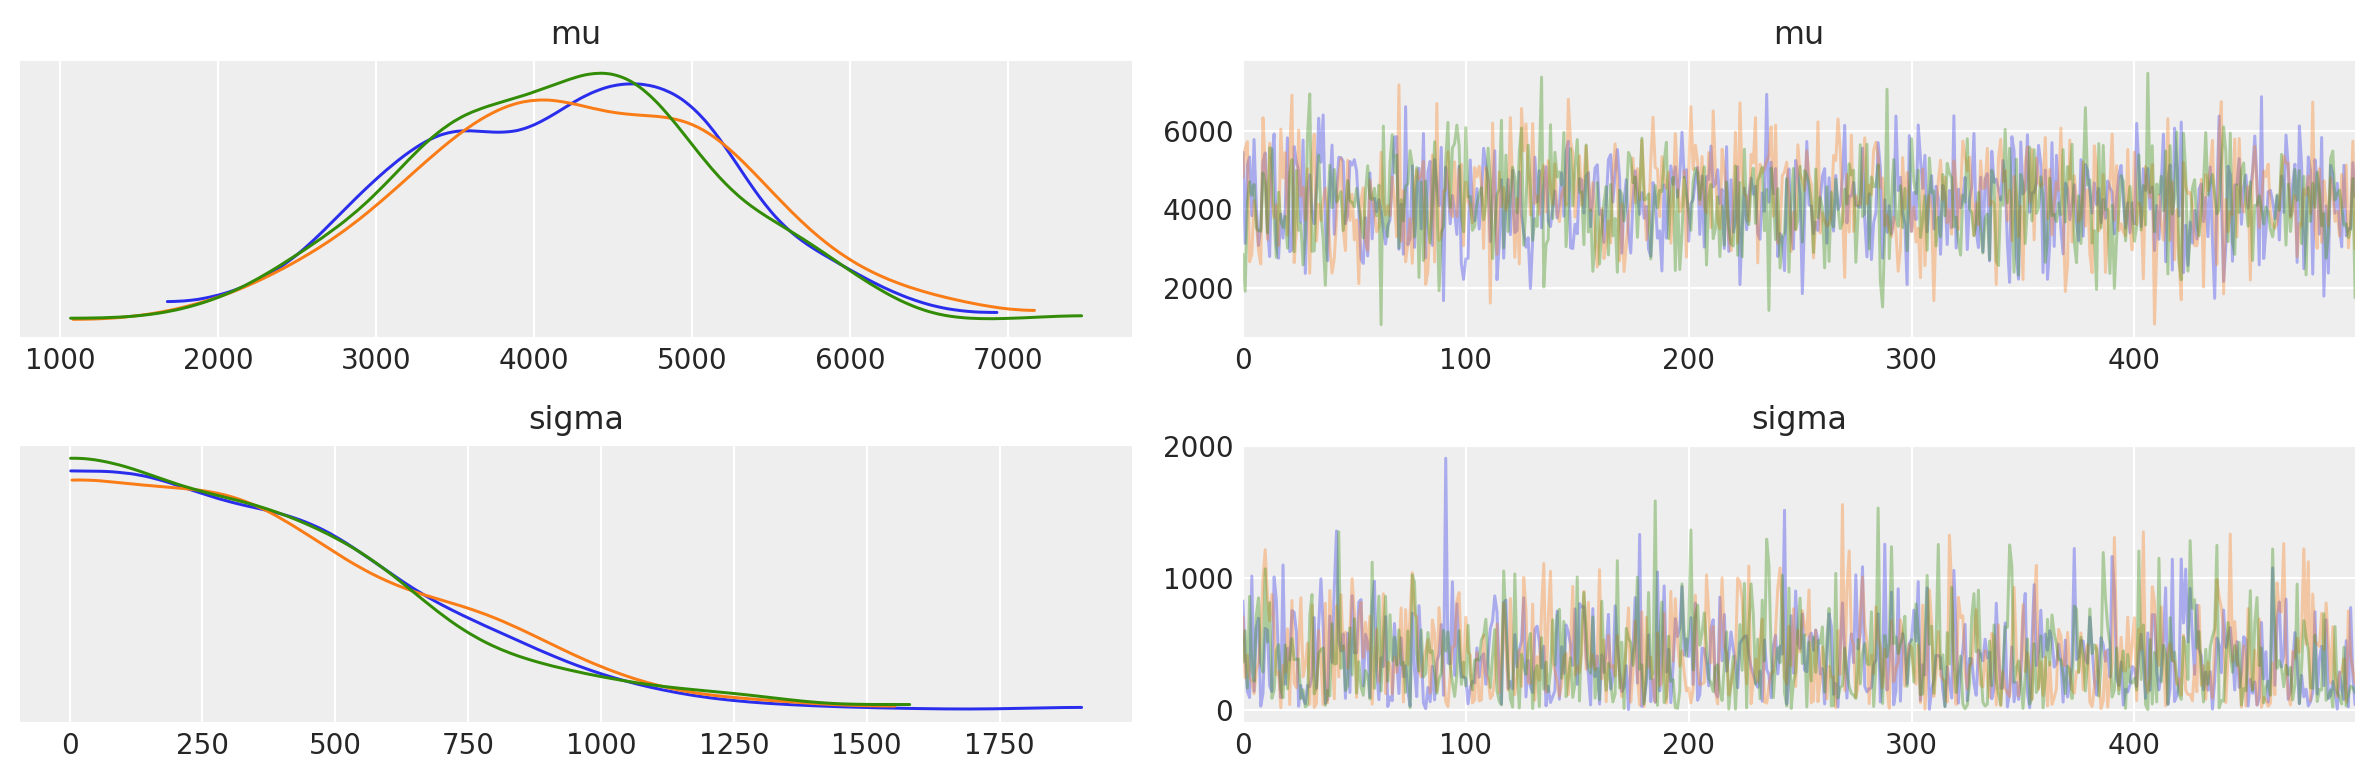

In [12]:
az.plot_trace(idata_prior.prior)
plt.tight_layout()
plt.show()

In [13]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:05.196100


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   5%|██▋                                                   | 100/2000 [00:01<00:04, 383.28it/s]

Running chain 2:   5%|██▋                                                   | 100/2000 [00:01<00:05, 347.42it/s]

Running chain 1:   5%|██▋                                                   | 100/2000 [00:01<00:05, 345.74it/s]

Running chain 3:   5%|██▋                                                   | 100/2000 [00:01<00:06, 296.54it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1186.41it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1187.41it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1188.33it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1189.28it/s]


Sampling time = 0:00:01.910511


Transforming variables...


Transformation time = 0:00:00.064580


Computing Log Likelihood...


Log Likelihood time = 0:00:00.235821


/var/folders/cl/wwjrsxdd5tz7y9jr82nd5hrw0000gn/T/ipykernel_79022/2491313140.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


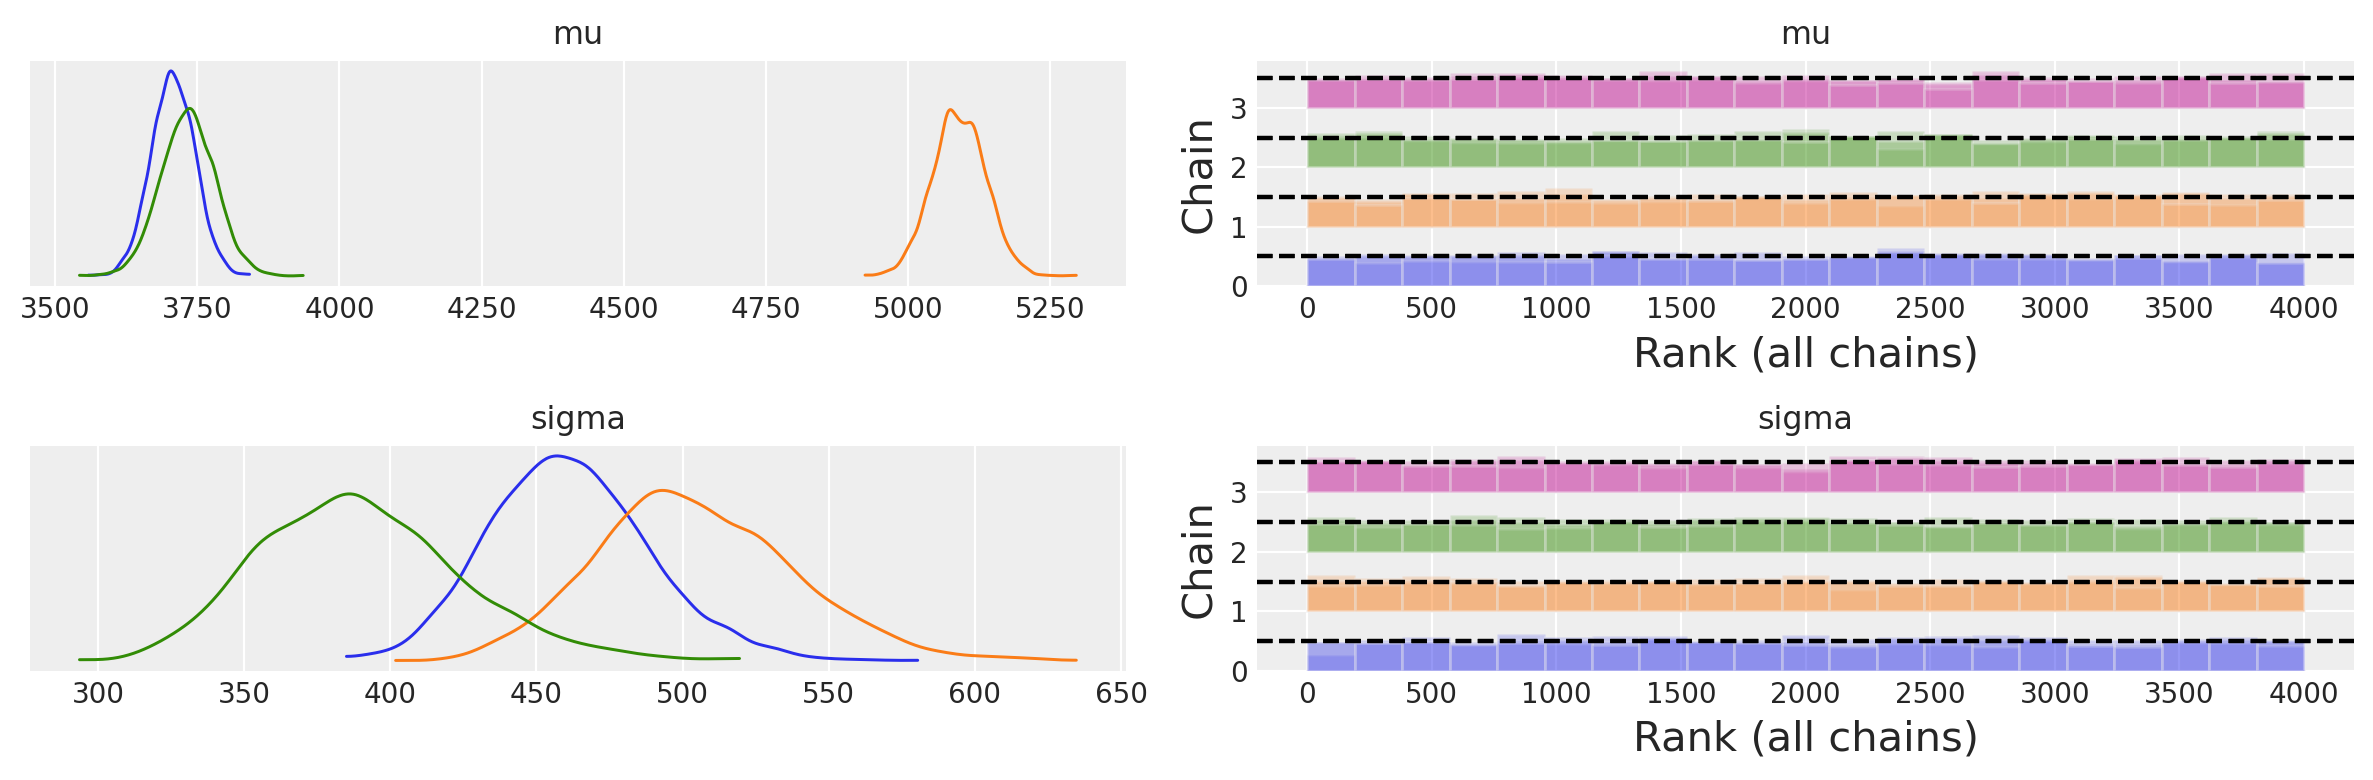

In [14]:
axes = az.plot_trace(idata, combined=True, kind="rank_bars")
plt.tight_layout()
plt.show()

In [15]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[Adelie],3707.200,38.413,3635.967,3780.012,0.545,0.385,4997.0,3024.0,1.0
mu[Gentoo],5090.362,46.745,5001.172,5175.624,0.630,0.445,5502.0,3089.0,1.0
mu[Chinstrap],3733.460,47.605,3640.658,3818.996,0.658,0.465,5283.0,2890.0,1.0
sigma[Adelie],461.258,27.303,413.256,515.805,0.385,0.276,5213.0,2775.0,1.0
sigma[Gentoo],504.211,33.608,443.566,568.900,0.441,0.316,5941.0,2968.0,1.0
sigma[Chinstrap],389.604,34.328,326.880,454.501,0.478,0.343,5253.0,3021.0,1.0


In [16]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean", "std", "count"])
)
summary_stats.round(1)

body_mass_g             
                 mean    std count
species                           
Adelie         3706.2  458.6   146
Chinstrap      3733.1  384.3    68
Gentoo         5092.4  501.5   119

In [17]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [18]:
mu_post = idata.posterior['mu']

In [19]:
mu_post.shape

(4, 1000, 3)

In [20]:
print(mu_post[:, :, 0].mean())

<xarray.DataArray 'mu' ()>
array(3707.20032694)
Coordinates:
    species  <U9 'Adelie'


In [21]:
np.array(
    [mu_post[:, :, 0].mean(), mu_post[:, :, 1].mean(), mu_post[:, :, 2].mean()]
).round(1)

array([3707.2, 5090.4, 3733.5])

In [22]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean"])
)
summary_stats.round(1)

,body_mass_g
,mean
species,
Adelie,3706.2
Chinstrap,3733.1
Gentoo,5092.4


In [23]:
sigma_post = idata.posterior["sigma"]
np.array(
    [sigma_post[:, :, 0].mean(), sigma_post[:, :, 1].mean(), sigma_post[:, :, 2].mean()]
).round(1)

array([461.3, 504.2, 389.6])

In [24]:
np.mean([mu_post[:, :, 0] < mu_post[:, :, 1]])

1.0

In [25]:
np.mean([mu_post[:, :, 0] < mu_post[:, :, 2]])

0.66575

In [26]:
np.mean([mu_post[:, :, 1] < mu_post[:, :, 2]])

0.0

In [27]:
np.mean([sigma_post[:, :, 0] < sigma_post[:, :, 2]])

0.0575

In [28]:
%run ../wm.py

Watermark:
----------
Last updated: 2024-01-26T19:00:13.229868+01:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit


